In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import flax.linen as nn
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import pandas as pd
import seaborn as sns
from flax.training import train_state
from jax import random

from neurovae import Conv2DVAE, bce_loss, gaussian_kld, load_mnist, plot_digits
from plot_utils import save_comparison, save_samples

sns.set_theme(context="paper", style="darkgrid", rc={"axes.facecolor": "0.96"})
fontsize = "x-large"
params = {
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize,
    "ytick.labelsize": fontsize,
    "legend.handlelength": 2,
}
plt.rcParams.update(params)

2024-06-24 03:32:37.513276: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def run(beta):

    latent_dim = 20
    batch_size = 64
    epochs = 100
    seed = 42

    batches, ds_test = load_mnist(
        batch_size=batch_size,
        drop_remainder=True,
        select_digits=[0, 1, 2, 3],
        as_supervised=False,
        binarized=True,
        shuffle=True,
        shuffle_seed=42,
    )

    # set values for learning rate scheduler
    total_steps = len(batches) * epochs
    init_lr = 1e-3
    alpha_lr = 1e-2

    ds_test = ds_test.reshape(-1, 28, 28, 1)
    ds_test = jax.device_put(ds_test)

    def model():
        return Conv2DVAE(latent_dim)

    def init_model(rng):
        rng, init_key = random.split(rng)

        initial_variables = jnp.ones((batch_size, 28, 28, 1), jnp.float32)
        params = model().init(init_key, initial_variables, rng)["params"]
        del initial_variables, init_key

        lr_schedule = optax.cosine_decay_schedule(init_lr, decay_steps=total_steps, alpha=alpha_lr)
        optimizer = optax.chain(optax.clip(1.0), optax.adamw(lr_schedule, nesterov=True))

        state = train_state.TrainState.create(
            apply_fn=model().apply,
            params=params,
            tx=optimizer,
        )
        return rng, state

    def compute_metrics(recon_x, x, mean, logvar):
        bce = bce_loss(recon_x, x).mean()  # mean over batch
        kld = gaussian_kld(mean, logvar).mean()  # mean over batch
        elbo = bce + beta * kld
        return {"elbo": elbo, "bce": bce, "kld": kld}

    @jax.jit
    def train_step(state, batch, z_rng):

        def loss_fn(params):
            recon_x, mean, logvar = model().apply({"params": params}, batch, z_rng)
            bce = bce_loss(recon_x, batch).mean()
            kld = gaussian_kld(mean, logvar).mean()
            elbo = bce + beta * kld
            return elbo

        grads = jax.grad(loss_fn)(state.params)
        return state.apply_gradients(grads=grads)

    @jax.jit
    def eval_f(params, images, z, z_rng):
        def eval_model(vae):
            recon_images, mean, logvar = vae(images, z_rng)

            recon_images_compare = nn.sigmoid(recon_images[:8])
            comparison = jnp.concatenate(
                [
                    images[:8],
                    recon_images_compare,
                ]
            )

            generate_images = vae.generate(z, assumption="bernoulli")
            generate_images = generate_images
            metrics = compute_metrics(recon_images, images, mean, logvar)
            return metrics, comparison, generate_images

        return nn.apply(eval_model, model())({"params": params})

    rng = random.key(seed)
    rng, state = init_model(rng)

    rng, z_key, eval_rng = random.split(rng, 3)

    z = random.normal(z_key, (batch_size, latent_dim))  # prior
    del z_key

    epoch_metrics = []
    for epoch in range(epochs):
        for batch in batches:
            batch = batch.reshape(-1, 28, 28, 1)
            rng, key = random.split(rng)
            state = train_step(state, batch, key)

        metrics, comparison, samples = eval_f(state.params, ds_test, z, eval_rng)
        metrics["epoch"] = epoch + 1
        epoch_metrics.append(metrics)
        print(f"epoch: {epoch + 1}, ELBO: {metrics['elbo']:.4f}, BCE: {metrics['bce']:.4f}, KLD: {metrics['kld']:.4f}")

    df = pd.DataFrame(epoch_metrics)
    df.to_csv(f"./vae_data/beta_{beta}_conv_vae_bmnist.csv", index=False)
    save_comparison(comparison, f"recon_beta_{beta}_conv_vae_bmnist.pdf")
    save_samples(samples, f"samples_beta_{beta}_conv_vae_bmnist.pdf")

epoch: 1, ELBO: 102.4317, BCE: 75.4856, KLD: 26.9461
epoch: 2, ELBO: 91.7418, BCE: 63.9584, KLD: 27.7834
epoch: 3, ELBO: 87.0162, BCE: 58.2742, KLD: 28.7420
epoch: 4, ELBO: 83.4858, BCE: 55.0568, KLD: 28.4290
epoch: 5, ELBO: 82.5750, BCE: 52.9729, KLD: 29.6021
epoch: 6, ELBO: 80.5735, BCE: 52.0037, KLD: 28.5699
epoch: 7, ELBO: 79.9368, BCE: 50.8581, KLD: 29.0786
epoch: 8, ELBO: 79.1182, BCE: 48.9526, KLD: 30.1656
epoch: 9, ELBO: 78.1883, BCE: 49.0472, KLD: 29.1411
epoch: 10, ELBO: 78.4722, BCE: 49.1499, KLD: 29.3223
epoch: 11, ELBO: 77.2000, BCE: 47.6859, KLD: 29.5141
epoch: 12, ELBO: 77.1414, BCE: 47.9597, KLD: 29.1818
epoch: 13, ELBO: 76.4437, BCE: 46.7393, KLD: 29.7043
epoch: 14, ELBO: 76.0983, BCE: 46.5651, KLD: 29.5332
epoch: 15, ELBO: 75.8382, BCE: 45.4853, KLD: 30.3529
epoch: 16, ELBO: 76.1240, BCE: 47.2362, KLD: 28.8879
epoch: 17, ELBO: 75.7651, BCE: 46.3468, KLD: 29.4182
epoch: 18, ELBO: 74.8714, BCE: 45.2112, KLD: 29.6602
epoch: 19, ELBO: 74.9814, BCE: 45.1849, KLD: 29.7965
e

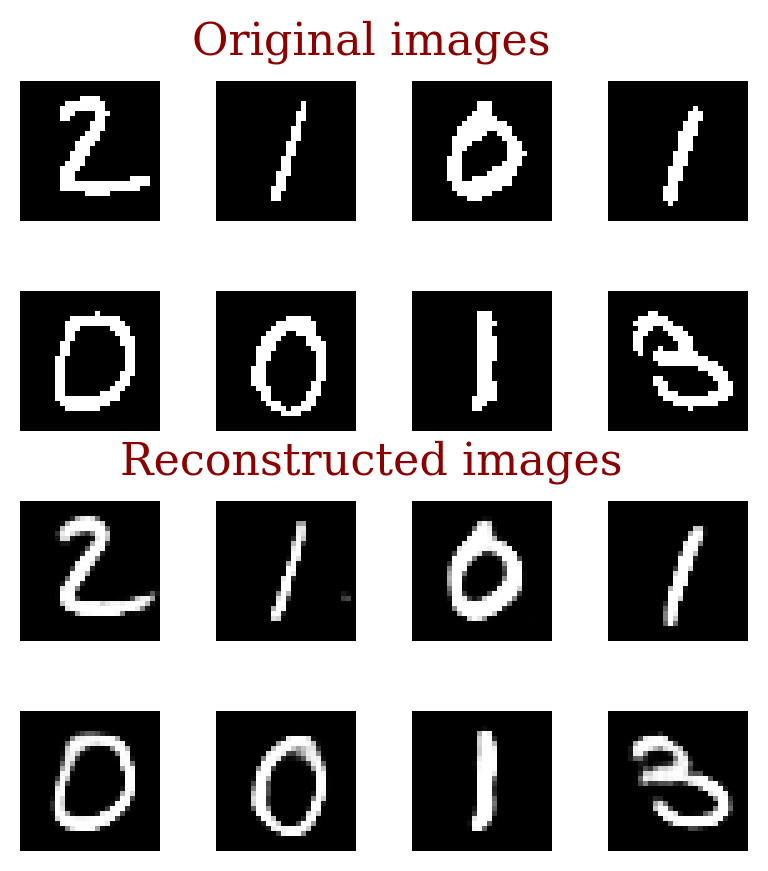

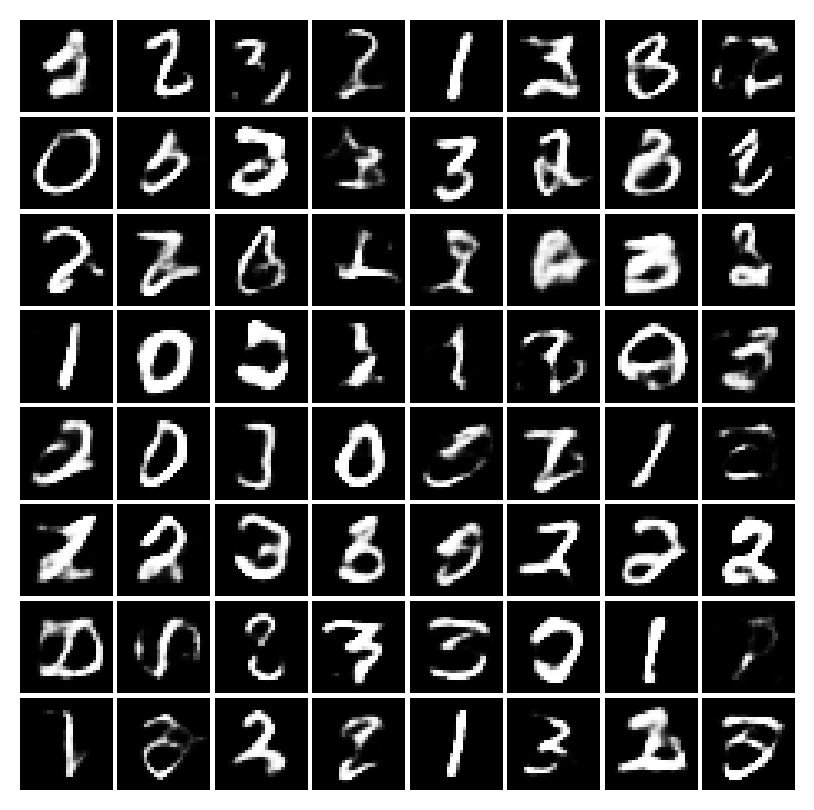

In [4]:
run(1)

epoch: 1, ELBO: 188.5483, BCE: 164.0091, KLD: 2.4539
epoch: 2, ELBO: 180.5959, BCE: 153.4337, KLD: 2.7162
epoch: 3, ELBO: 176.4063, BCE: 144.4652, KLD: 3.1941
epoch: 4, ELBO: 173.7096, BCE: 141.7472, KLD: 3.1962
epoch: 5, ELBO: 171.5335, BCE: 136.9494, KLD: 3.4584
epoch: 6, ELBO: 169.8686, BCE: 134.6253, KLD: 3.5243
epoch: 7, ELBO: 168.8375, BCE: 134.4663, KLD: 3.4371
epoch: 8, ELBO: 167.4115, BCE: 129.5961, KLD: 3.7815
epoch: 9, ELBO: 167.0048, BCE: 128.0380, KLD: 3.8967
epoch: 10, ELBO: 166.2781, BCE: 128.2341, KLD: 3.8044
epoch: 11, ELBO: 166.0380, BCE: 127.3259, KLD: 3.8712
epoch: 12, ELBO: 165.3826, BCE: 125.0440, KLD: 4.0339
epoch: 13, ELBO: 164.7701, BCE: 123.7126, KLD: 4.1057
epoch: 14, ELBO: 164.7703, BCE: 122.7857, KLD: 4.1985
epoch: 15, ELBO: 164.3198, BCE: 123.3039, KLD: 4.1016
epoch: 16, ELBO: 164.6234, BCE: 125.2411, KLD: 3.9382
epoch: 17, ELBO: 163.8391, BCE: 122.9729, KLD: 4.0866
epoch: 18, ELBO: 163.7844, BCE: 120.6055, KLD: 4.3179
epoch: 19, ELBO: 163.2999, BCE: 121.9

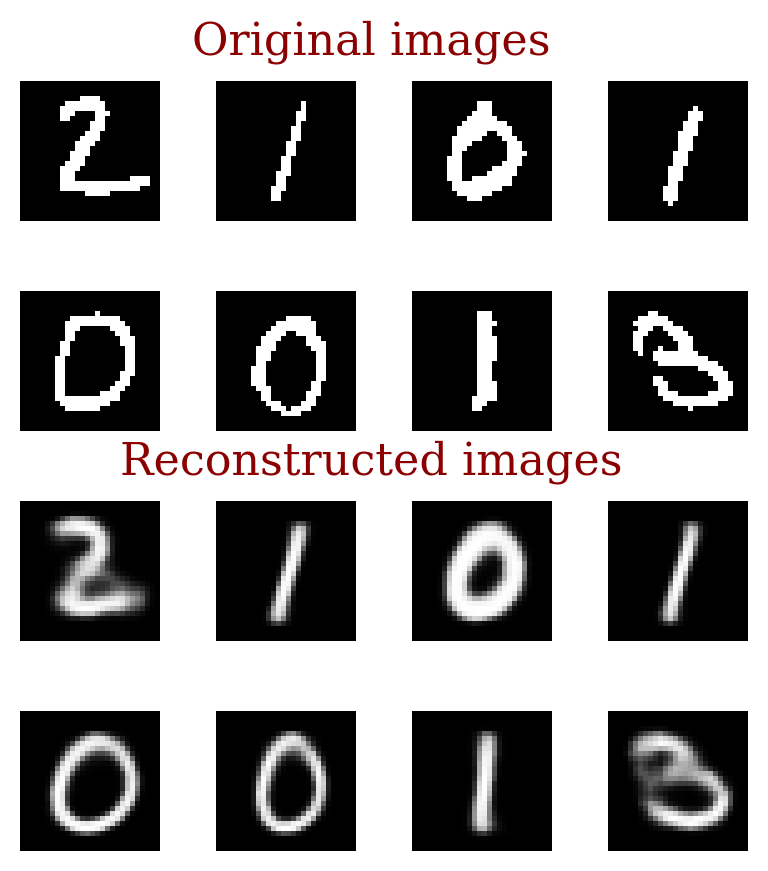

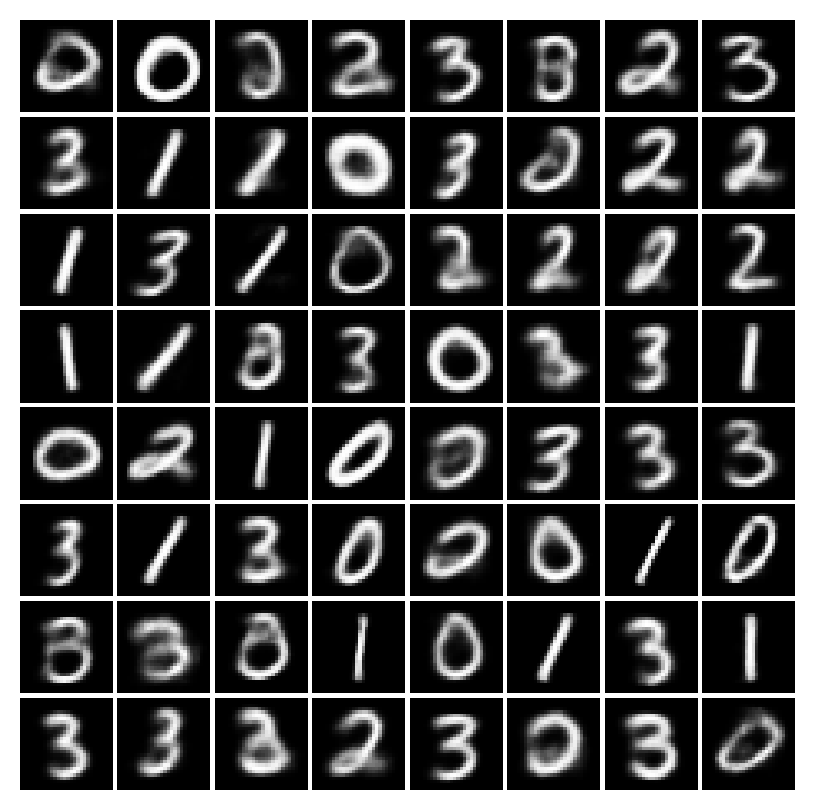

In [5]:
run(10)

epoch: 1, ELBO: 66.5316, BCE: 60.0922, KLD: 64.3941
epoch: 2, ELBO: 56.5189, BCE: 50.3516, KLD: 61.6723
epoch: 3, ELBO: 51.5404, BCE: 45.1748, KLD: 63.6556
epoch: 4, ELBO: 49.5736, BCE: 43.3363, KLD: 62.3728
epoch: 5, ELBO: 47.0032, BCE: 40.7346, KLD: 62.6859
epoch: 6, ELBO: 46.1558, BCE: 40.0070, KLD: 61.4873
epoch: 7, ELBO: 44.6896, BCE: 38.4181, KLD: 62.7150
epoch: 8, ELBO: 43.9486, BCE: 37.6876, KLD: 62.6099
epoch: 9, ELBO: 43.4005, BCE: 37.0572, KLD: 63.4328
epoch: 10, ELBO: 42.7483, BCE: 36.4796, KLD: 62.6874
epoch: 11, ELBO: 42.4925, BCE: 36.2115, KLD: 62.8096
epoch: 12, ELBO: 42.8516, BCE: 36.6233, KLD: 62.2833
epoch: 13, ELBO: 41.6378, BCE: 35.4158, KLD: 62.2196
epoch: 14, ELBO: 41.6955, BCE: 35.4666, KLD: 62.2884
epoch: 15, ELBO: 41.1150, BCE: 34.8516, KLD: 62.6346
epoch: 16, ELBO: 42.6309, BCE: 36.3255, KLD: 63.0541
epoch: 17, ELBO: 41.1523, BCE: 34.7913, KLD: 63.6106
epoch: 18, ELBO: 42.4288, BCE: 36.1233, KLD: 63.0552
epoch: 19, ELBO: 40.8984, BCE: 34.6098, KLD: 62.8862
ep

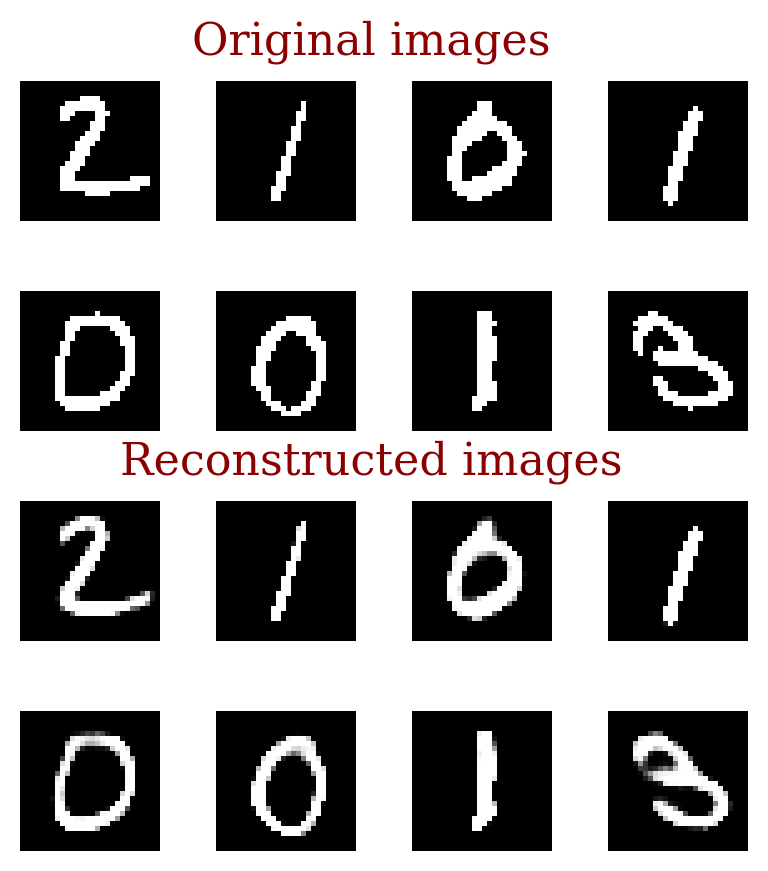

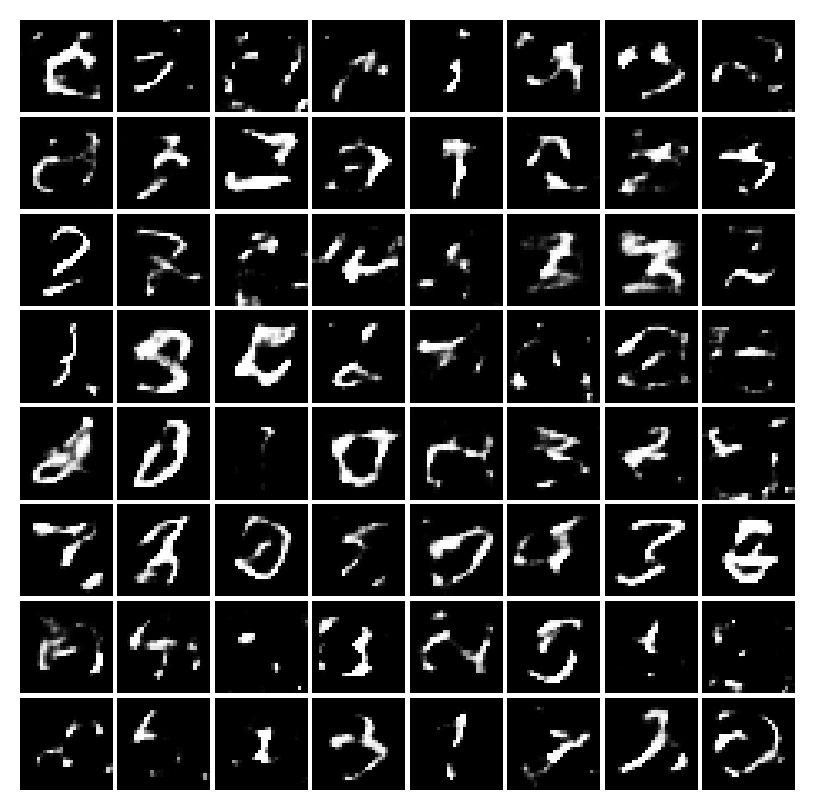

In [6]:
run(0.1)

epoch: 1, ELBO: 163.5993, BCE: 128.3959, KLD: 7.0407
epoch: 2, ELBO: 154.2021, BCE: 116.7862, KLD: 7.4832
epoch: 3, ELBO: 148.7107, BCE: 106.2462, KLD: 8.4929
epoch: 4, ELBO: 145.9052, BCE: 104.5131, KLD: 8.2784
epoch: 5, ELBO: 144.2053, BCE: 100.8759, KLD: 8.6659
epoch: 6, ELBO: 141.9582, BCE: 99.1151, KLD: 8.5686
epoch: 7, ELBO: 140.6115, BCE: 97.2915, KLD: 8.6640
epoch: 8, ELBO: 139.9014, BCE: 93.9844, KLD: 9.1834
epoch: 9, ELBO: 138.9972, BCE: 95.3210, KLD: 8.7352
epoch: 10, ELBO: 138.3478, BCE: 93.6515, KLD: 8.9393
epoch: 11, ELBO: 137.8123, BCE: 92.7875, KLD: 9.0049
epoch: 12, ELBO: 136.7156, BCE: 91.6137, KLD: 9.0204
epoch: 13, ELBO: 135.9504, BCE: 90.4268, KLD: 9.1047
epoch: 14, ELBO: 135.6868, BCE: 90.5834, KLD: 9.0207
epoch: 15, ELBO: 135.1121, BCE: 89.9683, KLD: 9.0288
epoch: 16, ELBO: 135.4970, BCE: 90.7107, KLD: 8.9573
epoch: 17, ELBO: 134.6892, BCE: 88.8506, KLD: 9.1677
epoch: 18, ELBO: 134.2623, BCE: 88.7116, KLD: 9.1101
epoch: 19, ELBO: 134.2220, BCE: 86.8794, KLD: 9.46

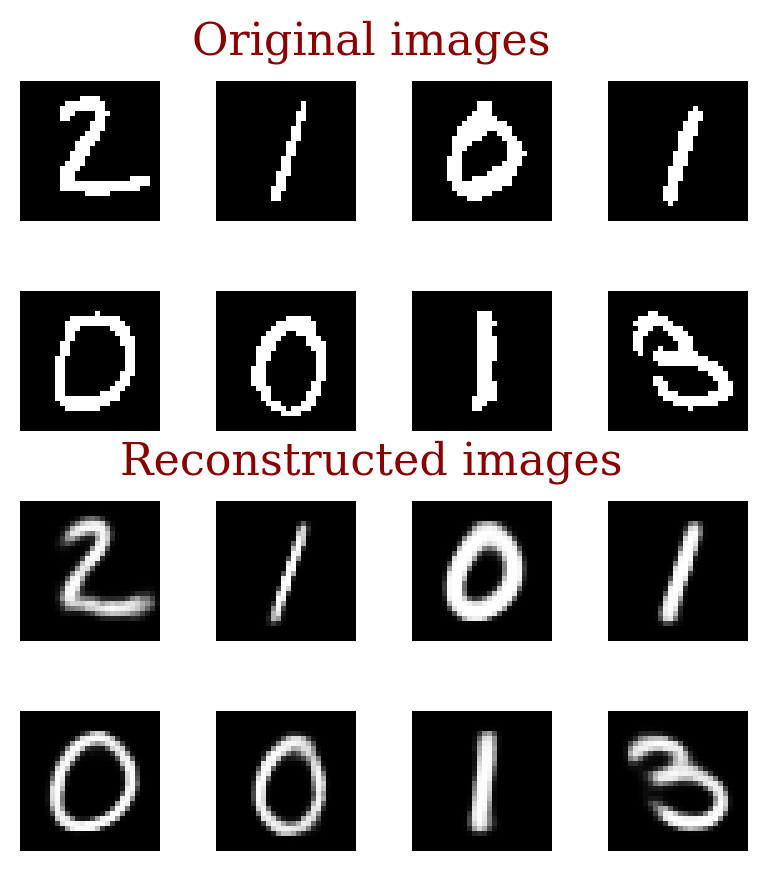

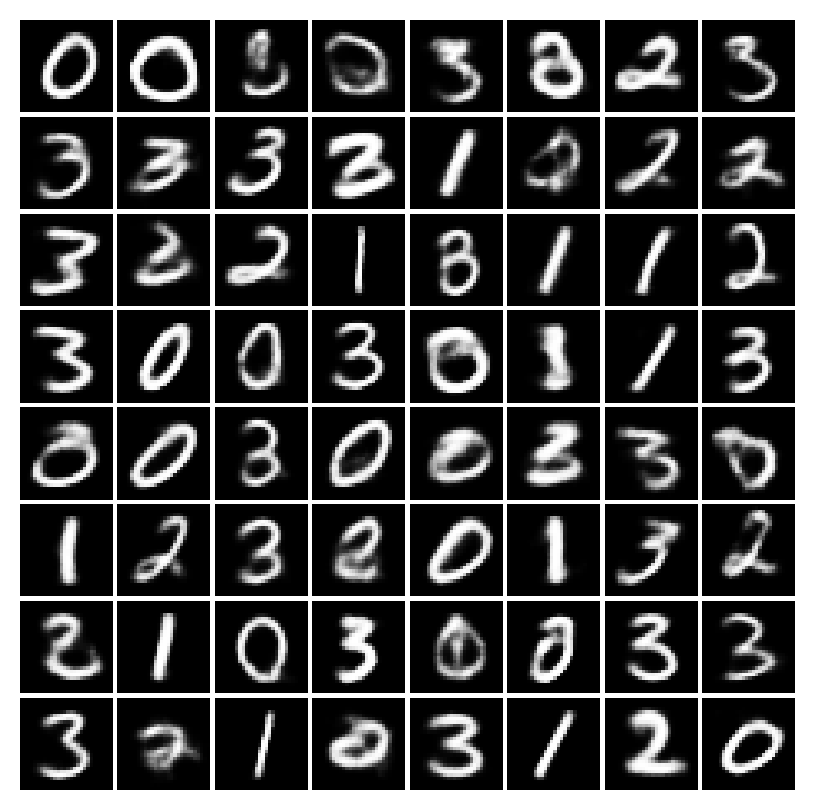

In [7]:
run(5)

epoch: 1, ELBO: 84.8665, BCE: 66.2353, KLD: 37.2625
epoch: 2, ELBO: 74.6967, BCE: 55.9636, KLD: 37.4663
epoch: 3, ELBO: 69.9388, BCE: 50.5058, KLD: 38.8660
epoch: 4, ELBO: 67.5951, BCE: 48.1439, KLD: 38.9024
epoch: 5, ELBO: 65.5309, BCE: 45.5334, KLD: 39.9950
epoch: 6, ELBO: 64.4604, BCE: 45.0852, KLD: 38.7504
epoch: 7, ELBO: 63.3483, BCE: 43.5507, KLD: 39.5953
epoch: 8, ELBO: 63.6062, BCE: 43.4828, KLD: 40.2469
epoch: 9, ELBO: 62.1373, BCE: 42.3230, KLD: 39.6287
epoch: 10, ELBO: 62.3422, BCE: 42.1948, KLD: 40.2949
epoch: 11, ELBO: 61.0994, BCE: 40.9869, KLD: 40.2249
epoch: 12, ELBO: 60.7404, BCE: 41.0125, KLD: 39.4557
epoch: 13, ELBO: 60.7016, BCE: 40.6620, KLD: 40.0793
epoch: 14, ELBO: 59.7154, BCE: 39.6109, KLD: 40.2091
epoch: 15, ELBO: 59.8421, BCE: 39.6663, KLD: 40.3517
epoch: 16, ELBO: 59.4232, BCE: 39.6594, KLD: 39.5276
epoch: 17, ELBO: 59.3061, BCE: 39.1271, KLD: 40.3581
epoch: 18, ELBO: 59.2929, BCE: 39.2335, KLD: 40.1188
epoch: 19, ELBO: 58.9897, BCE: 38.8769, KLD: 40.2257
ep

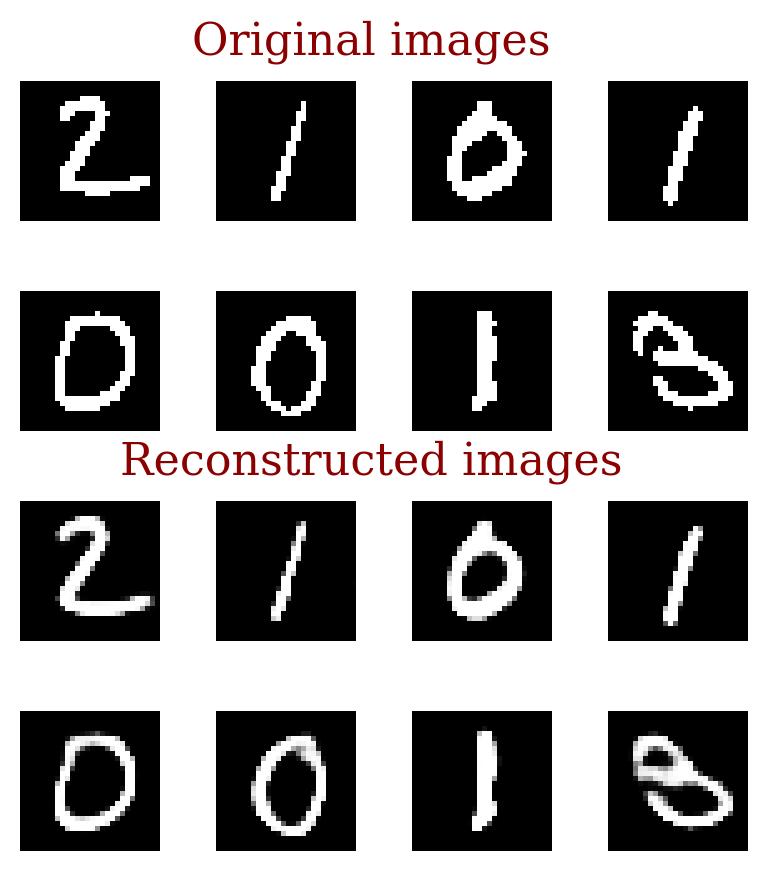

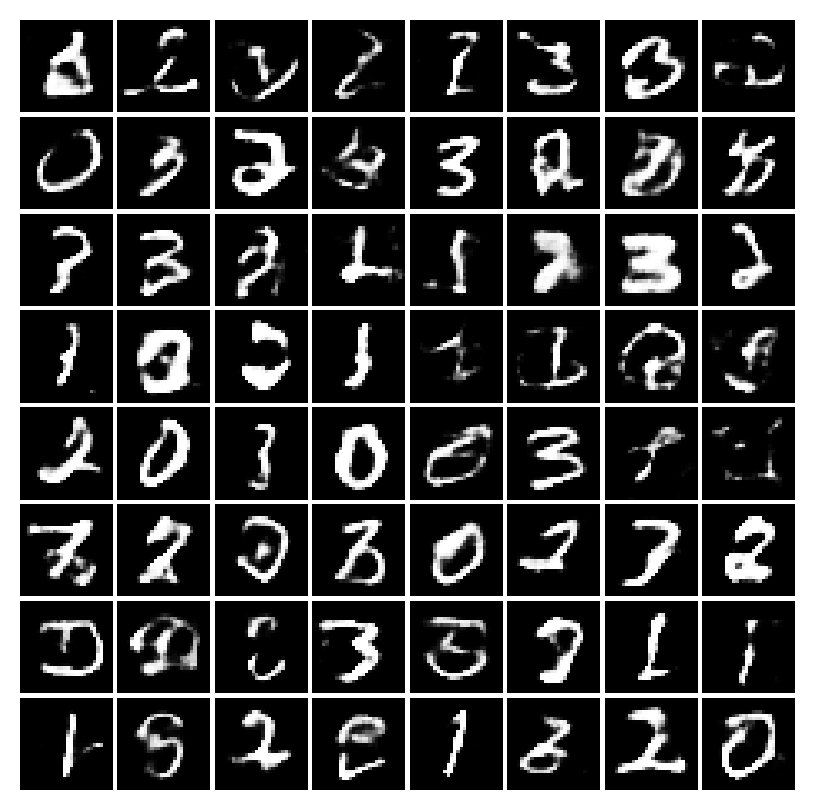

In [8]:
run(0.5)

epoch: 1, ELBO: 127.3622, BCE: 91.9551, KLD: 17.7035
epoch: 2, ELBO: 114.5429, BCE: 78.7798, KLD: 17.8816
epoch: 3, ELBO: 111.9860, BCE: 73.4440, KLD: 19.2710
epoch: 4, ELBO: 107.1728, BCE: 69.7870, KLD: 18.6929
epoch: 5, ELBO: 105.1013, BCE: 66.1250, KLD: 19.4881
epoch: 6, ELBO: 104.0660, BCE: 65.5944, KLD: 19.2358
epoch: 7, ELBO: 103.2736, BCE: 65.4662, KLD: 18.9037
epoch: 8, ELBO: 102.2906, BCE: 62.6831, KLD: 19.8038
epoch: 9, ELBO: 101.9299, BCE: 62.3808, KLD: 19.7746
epoch: 10, ELBO: 101.5069, BCE: 61.9847, KLD: 19.7611
epoch: 11, ELBO: 100.1295, BCE: 61.0066, KLD: 19.5614
epoch: 12, ELBO: 99.8698, BCE: 60.7114, KLD: 19.5792
epoch: 13, ELBO: 99.5899, BCE: 60.4071, KLD: 19.5914
epoch: 14, ELBO: 98.7562, BCE: 59.6135, KLD: 19.5713
epoch: 15, ELBO: 98.6887, BCE: 59.2353, KLD: 19.7267
epoch: 16, ELBO: 98.1263, BCE: 59.8862, KLD: 19.1201
epoch: 17, ELBO: 98.1731, BCE: 59.6328, KLD: 19.2701
epoch: 18, ELBO: 97.5457, BCE: 59.1836, KLD: 19.1811
epoch: 19, ELBO: 97.5131, BCE: 58.1217, KLD:

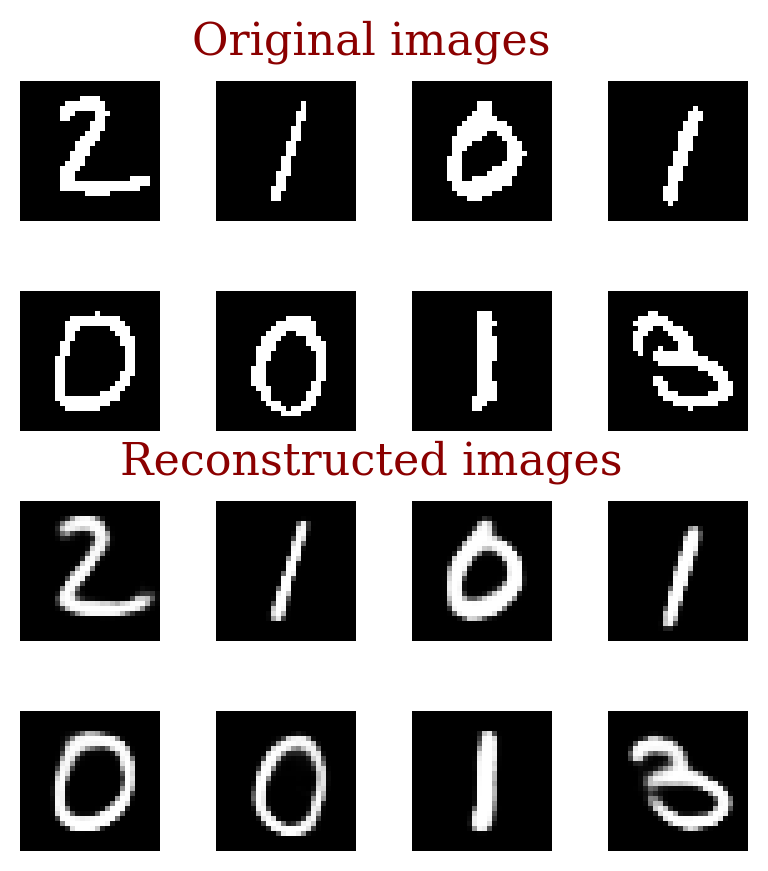

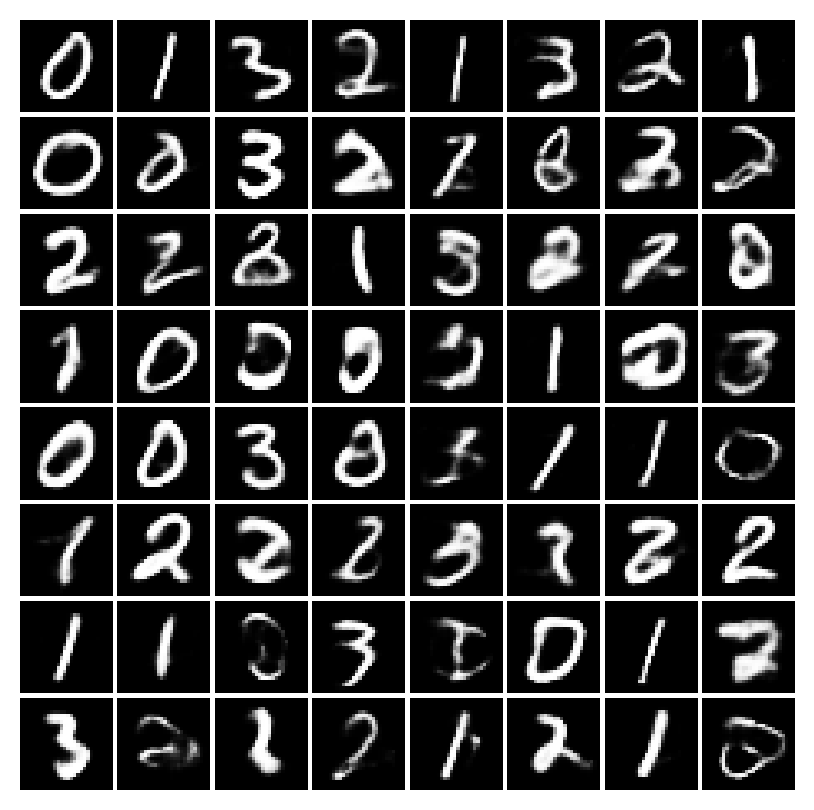

In [9]:
run(2)